# Introduction to Blocks

Where Spaces describe structure Blocks describe function. They can represent how two spaces are related to each other or how a space is related to itself. Generally speaking, a block is any transformation that takes inputs typed by spaces and returns outputs typed by spaces. In this introduction to blocks we will show how to construct blocks by first identifying the spaces which are the domains and codomains, then providing logic to map from points from the domain onto points in the codomain.

In [1]:
from typing import List, Tuple, Callable
import numpy as np

In [2]:
particle = {'schema': {'location': np.ndarray[tuple[int, int], float], 'direction': np.ndarray[tuple[int, int], float]},
          'description': "A particle on a cartesian plane with a location and a direction."
          }

particle

{'schema': {'location': numpy.ndarray[tuple[int, int], float],
  'direction': numpy.ndarray[tuple[int, int], float]},
 'description': 'A particle on a cartesian plane with a location and a direction.'}

We now want to introduce a constraint that does a type check for all of the fields in the schema because we will later use these checks when recieving a point as input to a block that is suppose to satisfy the constraints of the space that is its domain. And we will also want to check that a new point created by executing the logic of a block satifies the constraints of the space that is its codomain.

In [3]:
def particleSchemaCheck(point) -> bool:
    bit = True
    
    #check if the point is a dictionary
    if not isinstance(point, dict):
        print("point is not a dictionary")
        return False
    
    #check if the point has key 'location'
    if 'location' not in point:
        print("point does not have key 'location'")
        return False
    
    #check if the point has key 'direction'
    if 'direction' not in point:
        print("point does not have key 'direction'")
        return False
    
    #check if the value of 'location' is a numpy array
    if not isinstance(point['location'], np.ndarray):
        print("value of 'location' is not a numpy array")
        return False
    
    #check if the value of 'direction' is a numpy array
    if not isinstance(point['direction'], np.ndarray):
        print("value of 'direction' is not a numpy array")
        return False
    
    #check if the shape of 'location' is (2,)
    if point['location'].shape != (2,):
        print("shape of 'location' is not (2,)")
        return False
    
    #check if the shape of 'direction' is (2,)
    if point['direction'].shape != (2,):
        print("shape of 'direction' is not (2,)")
        return False
    
    return bit

particle['constraint'] = particleSchemaCheck

Now that we have a space representing a simple particle in a Cartesian Plane, lets create a block to describe its motion. Initially we know that a block describing the motion of a particle should take the current state of the particle in and return the new state of the particle, so we know that both its domain and its codomain must be `particle`.

In [4]:
motion_block = {'domain':particle, 'codomain':particle}
print(motion_block)

{'domain': {'schema': {'location': numpy.ndarray[tuple[int, int], float], 'direction': numpy.ndarray[tuple[int, int], float]}, 'description': 'A particle on a cartesian plane with a location and a direction.', 'constraint': <function particleSchemaCheck at 0x11d4de980>}, 'codomain': {'schema': {'location': numpy.ndarray[tuple[int, int], float], 'direction': numpy.ndarray[tuple[int, int], float]}, 'description': 'A particle on a cartesian plane with a location and a direction.', 'constraint': <function particleSchemaCheck at 0x11d4de980>}}


Now we need to equip the block with some logic -- let's suppose that we have a discrete time dynamical system with the following law of motion

1. **Position Update Equations**:
  $$ x^+ = x + \dot x \frac{\Delta t + (1 - f)^{\Delta t}}{2} $$
  $$ y^+ = y + \dot y \frac{\Delta t + (1 - f)^{\Delta t}}{2} $$

   These equations update the position of the particle in the x and y directions, respectively. The new position (\(x^+\) and \(y^+\)) is calculated based on the current position (\(x\) and \(y\)) and the current velocity (\(\dot x\) and \(\dot y\)). The term \(\frac{\Delta t + (1 - f)^{\Delta t}}{2}\) represents a time-dependent factor that incorporates both the time step (\(\Delta t\)) and a damping effect due to friction (\(f\)). The damping effect reduces the influence of the velocity over time, simulating a slowing down of the particle's motion.

1. **Velocity Update Equations**:
  $$ \dot x^+ = \dot x (1 - f)^{\Delta t} $$
  $$ \dot y^+ = \dot y (1 - f)^{\Delta t} $$

   These equations update the velocity of the particle in the x and y directions. The new velocity (\(\dot x^+\) and \(\dot y^+\)) is calculated by applying a damping factor \((1 - f)^{\Delta t}\) to the current velocity. This means that the velocity decreases over time due to the friction coefficient \(f\), simulating a loss of speed as the particle moves.

Overall, this set of equations models the motion of a particle under the influence of friction in a discrete time framework. The equations account for both the position and velocity updates, allowing for the simulation of realistic motion where the particle slows down over time due to frictional forces. This is commonly used in physics simulations, robotics, and game development to model the behavior of moving objects.

### Parameters

Based on the equations about our laws of motion require us to define our parameters in order to use them. We will first define a space that those paramters belong to, including constraining both time and friction to be positive, and setting our coef of friction to be within the interval $[0,1)$

In [5]:
paramSpace = {'schema': {'friction': float, 'dt': float}, 'constraint': lambda x: x['friction'] >= 0 and x['friction']<1 and x['dt'] > 0 }

In [6]:
paramPoint = {'friction': 0.5, 'dt': 0.1}
print(paramPoint)
print(paramSpace['constraint'](paramPoint))

{'friction': 0.5, 'dt': 0.1}
True


In [7]:
motion_block['paramSpace'] = paramSpace
motion_block

{'domain': {'schema': {'location': numpy.ndarray[tuple[int, int], float],
   'direction': numpy.ndarray[tuple[int, int], float]},
  'description': 'A particle on a cartesian plane with a location and a direction.',
  'constraint': <function __main__.particleSchemaCheck(point) -> bool>},
 'codomain': {'schema': {'location': numpy.ndarray[tuple[int, int], float],
   'direction': numpy.ndarray[tuple[int, int], float]},
  'description': 'A particle on a cartesian plane with a location and a direction.',
  'constraint': <function __main__.particleSchemaCheck(point) -> bool>},
 'paramSpace': {'schema': {'friction': float, 'dt': float},
  'constraint': <function __main__.<lambda>(x)>}}

### Motion Function Creator

In this section, we define the `motion_func_creator` function, which generates the logic for simulating the motion of a particle based on a specific set of parameters. 

The function takes `params` argument, which belongs to the defined parameter space (`paramSpace`). This space includes constraints for the coeficient of friction (`friction`) and time step (`dt`). 

The `motion_func` inner function, created within `motion_func_creator`, takes a `particle` as input and computes its new state based on the defined motion equations. It first checks if the input particle satisfies the domain constraints, then calculates the new location and direction of the particle using the motion update equations. Finally, it verifies that the resulting particle adheres to the codomain constraints before returning the updated particle.

This setup allows for flexible simulation of particle motion under varying conditions defined by the parameters in the parameter space.

In [8]:
def motion_func_creator(params: paramSpace) -> Callable[[particle], particle]:
    friction = params['friction']
    dt = params['dt']
    def motion_func(particle: particle) -> particle:
        
        #use the domain constraint to check the input
        assert motion_block['domain']['constraint'](particle)

        new_particle = {}
        new_particle['location'] = particle['location'] + particle['direction'] * ((dt + (1 - friction)**dt) / 2)
        new_particle['direction'] = particle['direction'] * ((1 - friction)**dt)

        #use the codomain constraint to check the output
        assert motion_block['codomain']['constraint'](new_particle)

        return new_particle
    return motion_func

In [9]:
motion_func = motion_func_creator(paramPoint)
motion_func

<function __main__.motion_func_creator.<locals>.motion_func(particle: {'schema': {'location': numpy.ndarray[tuple[int, int], float], 'direction': numpy.ndarray[tuple[int, int], float]}, 'description': 'A particle on a cartesian plane with a location and a direction.', 'constraint': <function particleSchemaCheck at 0x11d4de980>}) -> {'schema': {'location': numpy.ndarray[tuple[int, int], float], 'direction': numpy.ndarray[tuple[int, int], float]}, 'description': 'A particle on a cartesian plane with a location and a direction.', 'constraint': <function particleSchemaCheck at 0x11d4de980>}>

Now that we have a `motion_func` which satisfies all the rules of `motion_block` we save it as the logic for the block, bearing in mind that the paramSpace parameterizes a variety of possible `logic` values -- we still need to select one in order to make the block executable.

In [10]:
motion_block['logic'] = motion_func
motion_block

{'domain': {'schema': {'location': numpy.ndarray[tuple[int, int], float],
   'direction': numpy.ndarray[tuple[int, int], float]},
  'description': 'A particle on a cartesian plane with a location and a direction.',
  'constraint': <function __main__.particleSchemaCheck(point) -> bool>},
 'codomain': {'schema': {'location': numpy.ndarray[tuple[int, int], float],
   'direction': numpy.ndarray[tuple[int, int], float]},
  'description': 'A particle on a cartesian plane with a location and a direction.',
  'constraint': <function __main__.particleSchemaCheck(point) -> bool>},
 'paramSpace': {'schema': {'friction': float, 'dt': float},
  'constraint': <function __main__.<lambda>(x)>},
 'logic': <function __main__.motion_func_creator.<locals>.motion_func(particle: {'schema': {'location': numpy.ndarray[tuple[int, int], float], 'direction': numpy.ndarray[tuple[int, int], float]}, 'description': 'A particle on a cartesian plane with a location and a direction.', 'constraint': <function particleS

We can invoke the block by calling its logic on a point in its domain to get a point in its codomain. Below we create a point, check that it satisfies the domain constraint, input its value to the block, collect the output and verify that it satisfies the codomain constraint.

In [11]:
particlet0 = {'location': np.array([0.0, 0.0]), 'direction': np.array([1.0, 1.0])}
print(motion_block['domain']['constraint'](particlet0))
particlet0

True


{'location': array([0., 0.]), 'direction': array([1., 1.])}

In [12]:
particlet1 = motion_block['logic'](particlet0)
print(motion_block['codomain']['constraint'](particlet1))
particlet1

True


{'location': array([0.5165165, 0.5165165]),
 'direction': array([0.93303299, 0.93303299])}

Since the domain and the codomain are the same space, we can make repeated calls to the same logic to produce a trajectory. 

**Trajectory** is the term we use for a sequence of points in the same space which are generated by recursively calling a block whose codomain matches its domain.

In [13]:
#create a list of particles by applying the motion function to the previous particle
def motion_sequence(particle: particle, n: int, motion_func: Callable[[particle], particle]) -> List[particle]:
    particles = [particle]
    for i in range(n):
        particles.append(motion_func(particles[-1]))
    return particles

trajectory= motion_sequence(particlet0, 25, motion_block['logic'])
trajectory

[{'location': array([0., 0.]), 'direction': array([1., 1.])},
 {'location': array([0.5165165, 0.5165165]),
  'direction': array([0.93303299, 0.93303299])},
 {'location': array([0.99844343, 0.99844343]),
  'direction': array([0.87055056, 0.87055056])},
 {'location': array([1.44809715, 1.44809715]),
  'direction': array([0.8122524, 0.8122524])},
 {'location': array([1.86763891, 1.86763891]),
  'direction': array([0.75785828, 0.75785828])},
 {'location': array([2.25908522, 2.25908522]),
  'direction': array([0.70710678, 0.70710678])},
 {'location': array([2.62431754, 2.62431754]),
  'direction': array([0.65975396, 0.65975396])},
 {'location': array([2.96509134, 2.96509134]),
  'direction': array([0.61557221, 0.61557221])},
 {'location': array([3.28304454, 3.28304454]),
  'direction': array([0.57434918, 0.57434918])},
 {'location': array([3.57970536, 3.57970536]),
  'direction': array([0.53588673, 0.53588673])},
 {'location': array([3.8564997, 3.8564997]), 'direction': array([0.5, 0.5])},


It can be helpful to visualize trajectories. Given the friction in our model, we can see that the particle is slowing down as it moves forward. 

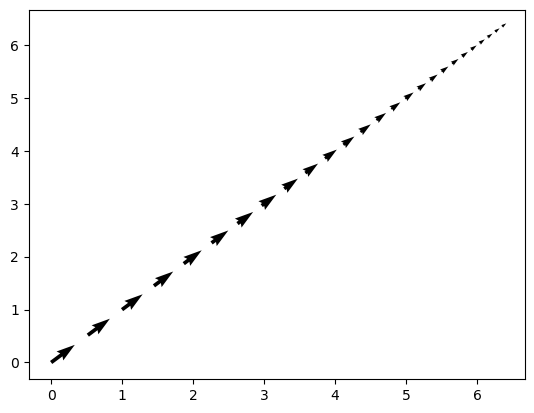

In [14]:
#plot the trajectory
import matplotlib.pyplot as plt
x = [p['location'][0] for p in trajectory]
y = [p['location'][1] for p in trajectory]
u = [p['direction'][0] for p in trajectory]
v = [p['direction'][1] for p in trajectory]
plt.quiver(x, y, u, v, scale=3, scale_units='xy', angles='xy')
plt.show()

### Parameter Sweeps in Dynamics Simulation

In this section, we will explore the concept of parameter sweeps, which allows us to observe how variations in parameters and initial conditions affect the dynamics of our particle motion simulation. By systematically changing parameters such as the coefficient of friction and the time step, as well as the initial conditions of the particles, we can generate a range of trajectories.

This approach is particularly useful in understanding the sensitivity of the system to different inputs. For instance, increasing the friction coefficient may lead to faster deceleration of the particle, while altering the time step can change the speed at which the dynamics unfold. By visualizing these trajectories, we can gain insights into the behavior of the system under various conditions, helping us to identify patterns and make informed decisions in applications such as physics simulations, robotics, and game development.

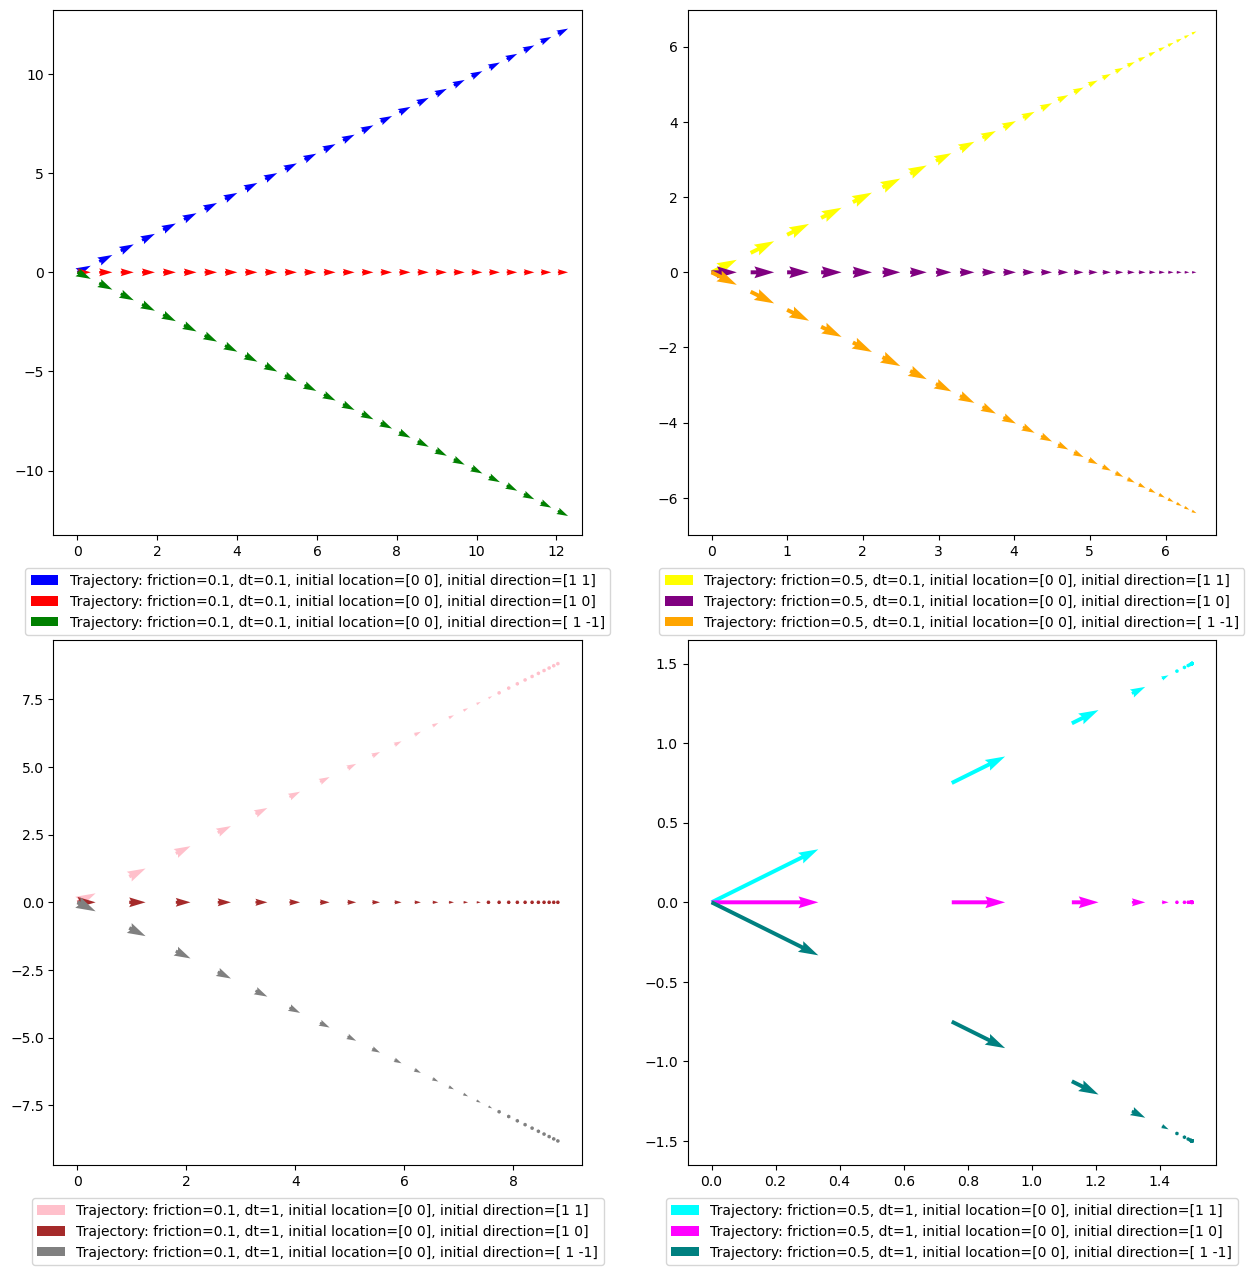

{'domain': {'schema': {'location': numpy.ndarray[tuple[int, int], float], 'direction': numpy.ndarray[tuple[int, int], float]}, 'description': 'A particle on a cartesian plane with a location and a direction.', 'constraint': <function particleSchemaCheck at 0x11d4de980>}, 'codomain': {'schema': {'location': numpy.ndarray[tuple[int, int], float], 'direction': numpy.ndarray[tuple[int, int], float]}, 'description': 'A particle on a cartesian plane with a location and a direction.', 'constraint': <function particleSchemaCheck at 0x11d4de980>}, 'paramSpace': {'schema': {'friction': <class 'float'>, 'dt': <class 'float'>}, 'constraint': <function <lambda> at 0x11d4dec00>}, 'logic': <function motion_func_creator.<locals>.motion_func at 0x11fdf3380>, 'params': {'friction': 0.1, 'dt': 0.1}}
{'domain': {'schema': {'location': numpy.ndarray[tuple[int, int], float], 'direction': numpy.ndarray[tuple[int, int], float]}, 'description': 'A particle on a cartesian plane with a location and a direction.'

In [29]:
# create a loop we change the parameters and the initial conditions and replot the trajectory
paramPoints = [{'friction': 0.1, 'dt': 0.1}, {'friction': 0.5, 'dt': 0.1}, {'friction': 0.1, 'dt': 1},  {'friction': 0.5, 'dt': 1}]
particlet0s = [{'location': np.array([0, 0]), 'direction': np.array([1, 1])}, {'location': np.array([0, 0]), 'direction': np.array([1, 0])}, {'location': np.array([0, 0]), 'direction': np.array([1, -1])}]

colors = ['blue', 'red', 'green', 'yellow', 'purple', 'orange', 'pink', 'brown', 'grey', 'cyan', 'magenta', 'teal']
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# create a list of blocks with different parameters and initial conditions
blocks = []

for i, paramPoint in enumerate(paramPoints):
    
    motion_func = motion_func_creator(paramPoint)
    block = {'domain':particle, 'codomain':particle, 'paramSpace':paramSpace, 'logic':motion_func, 'params':paramPoint}
    blocks.append(block)

    for j, particlet0 in enumerate(particlet0s):
        trajectory = motion_sequence(particlet0, 25, block['logic'])
        x = [p['location'][0] for p in trajectory]
        y = [p['location'][1] for p in trajectory]
        u = [p['direction'][0] for p in trajectory]
        v = [p['direction'][1] for p in trajectory]

        
        axs[i//2, i%2].quiver(x, y, u, v, scale=3, scale_units='xy', angles='xy', color=colors[(i*len(particlet0s)+j)%len(colors)], label=f"Trajectory: friction={paramPoint['friction']}, dt={paramPoint['dt']}, initial location={particlet0['location']}, initial direction={particlet0['direction']}")
        axs[i//2, i%2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=1)
axs[1, 1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=1)

plt.show()
for block in blocks:
    print(block)

By looping over the block with different parameters and initial conditions we can clearly see the effects of the changes to the parameters. Larger `dt` leads to dynamics playing out faster, and larger `friction` leads to slowing down faster.